In [2]:
# load .pth model. 
# 1. load best epoch value from .pth file
# 2. get the accuracy at best epoch - this is the peak performance of the model
# 3. Get the epoch at at which the model reaches at least 80% of the peak performance
# 4. From durations.csv file, get total time taken to run the model, calculate - time taken to reach this convergence

import torch 
import os
import sys
import numpy as np
import pandas as pd

In [51]:
def get_thresh_and_time(model_path,  duration_path, thresh=0.8, total_epochs=80):
    # load model
    ckpt = torch.load(model_path, map_location='cpu')
    best_epoch = ckpt['epoch']
    best_accuracy = ckpt['val_iou_history'][-2] #penultimate value is the best accuracy
    print(f"Best epoch: {best_epoch}, Best accuracy: {best_accuracy:.4f}")

    # get the epoch at which the model reaches at least 80% of the peak performance
    thresh_accuracy = thresh * best_accuracy
    thresh_epoch = None
    for epoch, accuracy in enumerate(ckpt['val_iou_history']):
        if accuracy >= thresh_accuracy:
            thresh_epoch = epoch
            break
    print(f"Epoch at which model reaches at least {thresh*100}% of peak performance: {thresh_epoch}")

    # get the time taken to reach this convergence
    durations = pd.read_csv(duration_path)
    time_per_fold = durations.iloc[-1]['duration']/3         #-1 is the last row with total time, 3 is splits
    time_per_epoch = time_per_fold / total_epochs
    time_to_convergence = time_per_epoch * thresh_epoch
    print(f"Total time taken to run the model: {time_per_fold}, Time taken to reach convergence: {time_to_convergence}")   

    return thresh_epoch, time_to_convergence

In [52]:
def folds_analysis(base_path, thresh=0.8, total_epochs=80):
    thresh_epochs_lis = []
    time_to_convergence_lis = []

    for fold in range(3):
        model_path = os.path.join(base_path, 'model_outputs',f'fold_{fold}_best_model.pth')
        duration_path = os.path.join(base_path, 'quickview', 'durations.csv')
        print(f"\nFold {fold}")
        thresh_epoch, time_to_convergence = get_thresh_and_time(model_path, duration_path, thresh, total_epochs)
        thresh_epochs_lis.append(thresh_epoch)
        time_to_convergence_lis.append(time_to_convergence)

    mean_thresh_epoch = np.mean(thresh_epochs_lis)
    mean_time_to_converge = np.mean(time_to_convergence_lis)
    print(f"\nAverage epoch at which model reaches at least {thresh*100}% of peak performance: {mean_thresh_epoch}")
    print(f"Average time taken to reach convergence: {mean_time_to_converge}")

    return mean_thresh_epoch, mean_time_to_converge, thresh_epochs_lis, time_to_convergence_lis 

In [43]:
path = r'E:\Thesis\outputs\44975_20240525_siam_96\model_outputs\fold_0_best_model.pth'
dur_path = r'E:\Thesis\outputs\44975_20240525_siam_96\quickview\durations.csv'
thresh = 0.98
get_thresh_and_time(model_path= path,  duration_path=dur_path, thresh=thresh, total_epochs=80)

Best epoch: 64, Best accuracy: 0.3999
Epoch at which model reaches at least 98.0% of peak performance: 19
Total time taken to run the model: 277.0, Time taken to reach convergence: 65.7875


In [49]:
base_path = r'E:\Thesis\outputs\44975_20240525_siam_96'
thresh = 0.98
total_epochs = 80

folds_analysis(base_path, thresh, total_epochs)


Fold 0
Best epoch: 64, Best accuracy: 0.3999
Epoch at which model reaches at least 98.0% of peak performance: 19
Total time taken to run the model: 277.0, Time taken to reach convergence: 65.7875

Fold 1
Best epoch: 78, Best accuracy: 0.4057
Epoch at which model reaches at least 98.0% of peak performance: 20
Total time taken to run the model: 277.0, Time taken to reach convergence: 69.25

Fold 2
Best epoch: 52, Best accuracy: 0.4068
Epoch at which model reaches at least 98.0% of peak performance: 12
Total time taken to run the model: 277.0, Time taken to reach convergence: 41.55

Average epoch at which model reaches at least 98.0% of peak performance: 17.0
Average time taken to reach convergence: 58.86249999999999


(17.0, 58.86249999999999)

In [54]:
# for a given list of base_paths create a summary report dataframe with the following columns: model_base_name, for each fold (thresh_epoch,), mean_thresh_epoch, mean_time_to_converge

base_paths = [r'E:\Thesis\outputs\44975_20240525_siam_96', r'E:\Thesis\outputs\44975_20240525_siam_96']
thresh = 0.98
total_epochs = 80

summary = pd.DataFrame(columns=['model_base_name', 'fold_0_thresh_epoch', 'fold_1_thresh_epoch', 'fold_2_thresh_epoch', 
                                'fold_0_time_to_converge', 'fold_1_time_to_converge', 'fold_2_time_to_converge',
                                'mean_thresh_epoch', 'mean_time_to_converge'])

for base_path in base_paths:
    model_base_name = os.path.basename(base_path)
    mean_thresh_epoch, mean_time_to_converge, thresh_epochs_lis, time_to_convergence_lis = folds_analysis(base_path, thresh, total_epochs)
    summary_dict = {'model_base_name': model_base_name, 'mean_thresh_epoch': mean_thresh_epoch, 'mean_time_to_converge': mean_time_to_converge,
                    'fold_0_thresh_epoch': thresh_epochs_lis[0], 'fold_1_thresh_epoch': thresh_epochs_lis[1], 'fold_2_thresh_epoch': thresh_epochs_lis[2],
                    'fold_0_time_to_converge': time_to_convergence_lis[0], 'fold_1_time_to_converge': time_to_convergence_lis[1], 'fold_2_time_to_converge': time_to_convergence_lis[2]}
    summary = pd.concat([summary, pd.DataFrame(summary_dict, index=[0])], ignore_index=True)

summary['std_dev_thresh_epoch']= summary[['fold_0_thresh_epoch', 'fold_1_thresh_epoch', 'fold_2_thresh_epoch']].std(axis=1)
summary['std_dev_time_to_converge']= summary[['fold_0_time_to_converge', 'fold_1_time_to_converge', 'fold_2_time_to_converge']].std(axis=1)
summary




Fold 0
Best epoch: 64, Best accuracy: 0.3999
Epoch at which model reaches at least 98.0% of peak performance: 19
Total time taken to run the model: 277.0, Time taken to reach convergence: 65.7875

Fold 1
Best epoch: 78, Best accuracy: 0.4057
Epoch at which model reaches at least 98.0% of peak performance: 20
Total time taken to run the model: 277.0, Time taken to reach convergence: 69.25

Fold 2
Best epoch: 52, Best accuracy: 0.4068
Epoch at which model reaches at least 98.0% of peak performance: 12
Total time taken to run the model: 277.0, Time taken to reach convergence: 41.55

Average epoch at which model reaches at least 98.0% of peak performance: 17.0
Average time taken to reach convergence: 58.86249999999999

Fold 0
Best epoch: 64, Best accuracy: 0.3999
Epoch at which model reaches at least 98.0% of peak performance: 19
Total time taken to run the model: 277.0, Time taken to reach convergence: 65.7875

Fold 1
Best epoch: 78, Best accuracy: 0.4057
Epoch at which model reaches at 

,model_base_name,fold_0_thresh_epoch,fold_1_thresh_epoch,fold_2_thresh_epoch,fold_0_time_to_converge,fold_1_time_to_converge,fold_2_time_to_converge,mean_thresh_epoch,mean_time_to_converge,std_dev_thresh_epoch,std_dev_time_to_converge
0,44975_20240525_siam_96,19,20,12,65.7875,69.25,41.55,17.0,58.8625,4.358899,15.092688
1,44975_20240525_siam_96,19,20,12,65.7875,69.25,41.55,17.0,58.8625,4.358899,15.092688


In [61]:
def prepare_report(root_path, model_name_lis, thresh,total_epochs):

    summary = pd.DataFrame(columns=['model_base_name', 'fold_0_thresh_epoch', 'fold_1_thresh_epoch', 'fold_2_thresh_epoch', 
                                    'fold_0_time_to_converge', 'fold_1_time_to_converge', 'fold_2_time_to_converge',
                                    'mean_thresh_epoch', 'mean_time_to_converge'])

    for model_name in model_name_lis:
        model_path = os.path.join(root_path, model_name)
        mean_thresh_epoch, mean_time_to_converge, thresh_epochs_lis, time_to_convergence_lis = folds_analysis(model_path, thresh, total_epochs)
        
        summary_dict = {'model_base_name': model_name, 'mean_thresh_epoch': mean_thresh_epoch, 'mean_time_to_converge': mean_time_to_converge,
                        'fold_0_thresh_epoch': thresh_epochs_lis[0], 'fold_1_thresh_epoch': thresh_epochs_lis[1], 'fold_2_thresh_epoch': thresh_epochs_lis[2],
                        'fold_0_time_to_converge': time_to_convergence_lis[0], 'fold_1_time_to_converge': time_to_convergence_lis[1], 'fold_2_time_to_converge': time_to_convergence_lis[2]}
        summary = pd.concat([summary, pd.DataFrame(summary_dict, index=[0])], ignore_index=True)

    summary['std_dev_thresh_epoch']= summary[['fold_0_thresh_epoch', 'fold_1_thresh_epoch', 'fold_2_thresh_epoch']].std(axis=1)
    summary['std_dev_time_to_converge']= summary[['fold_0_time_to_converge', 'fold_1_time_to_converge', 'fold_2_time_to_converge']].std(axis=1)

    return summary
    

In [62]:
root_path =r'E:\Thesis\outputs'

model_name_lis = ['44946_20240524_s2', '44947_20240524_siam_18', '44948_20240524_siam_33', '44949_20240524_siam_48', '44975_20240525_siam_96', '44993_20240526_s2_siam_96']

summary_df = prepare_report(root_path, model_name_lis, thresh =0.98, total_epochs=80)


Fold 0
Best epoch: 62, Best accuracy: 0.4139
Epoch at which model reaches at least 98.0% of peak performance: 12
Total time taken to run the model: 319.6666666666667, Time taken to reach convergence: 47.95

Fold 1
Best epoch: 51, Best accuracy: 0.4261
Epoch at which model reaches at least 98.0% of peak performance: 19
Total time taken to run the model: 319.6666666666667, Time taken to reach convergence: 75.92083333333333

Fold 2
Best epoch: 69, Best accuracy: 0.4218
Epoch at which model reaches at least 98.0% of peak performance: 18
Total time taken to run the model: 319.6666666666667, Time taken to reach convergence: 71.92500000000001

Average epoch at which model reaches at least 98.0% of peak performance: 16.333333333333332
Average time taken to reach convergence: 65.26527777777778

Fold 0
Best epoch: 57, Best accuracy: 0.3664
Epoch at which model reaches at least 98.0% of peak performance: 9
Total time taken to run the model: 169.0, Time taken to reach convergence: 19.0125

Fold 1

In [63]:
summary_df

,model_base_name,fold_0_thresh_epoch,fold_1_thresh_epoch,fold_2_thresh_epoch,fold_0_time_to_converge,fold_1_time_to_converge,fold_2_time_to_converge,mean_thresh_epoch,mean_time_to_converge,std_dev_thresh_epoch,std_dev_time_to_converge
0,44946_20240524_s2,12,19,18,47.950000,75.920833,71.925000,16.333333,65.265278,3.785939,15.127981
1,44947_20240524_siam_18,9,16,5,19.012500,33.800000,10.562500,10.000000,21.125000,5.567764,11.761902
2,44948_20240524_siam_33,17,9,8,44.341667,23.475000,20.866667,11.333333,29.561111,4.932883,12.866603
3,44949_20240524_siam_48,25,17,4,67.500000,45.900000,10.800000,15.333333,41.400000,10.598742,28.616604
4,44975_20240525_siam_96,19,20,12,65.787500,69.250000,41.550000,17.000000,58.862500,4.358899,15.092688
5,44993_20240526_s2_siam_96,16,27,26,79.333333,133.875000,128.916667,23.000000,114.041667,6.082763,30.160364


C:\Users\User\AppData\Local\Temp\ipykernel_20184\3408925358.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(summary_df['model_base_name'], rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_20184\3408925358.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(summary_df['model_base_name'], rotation=45)


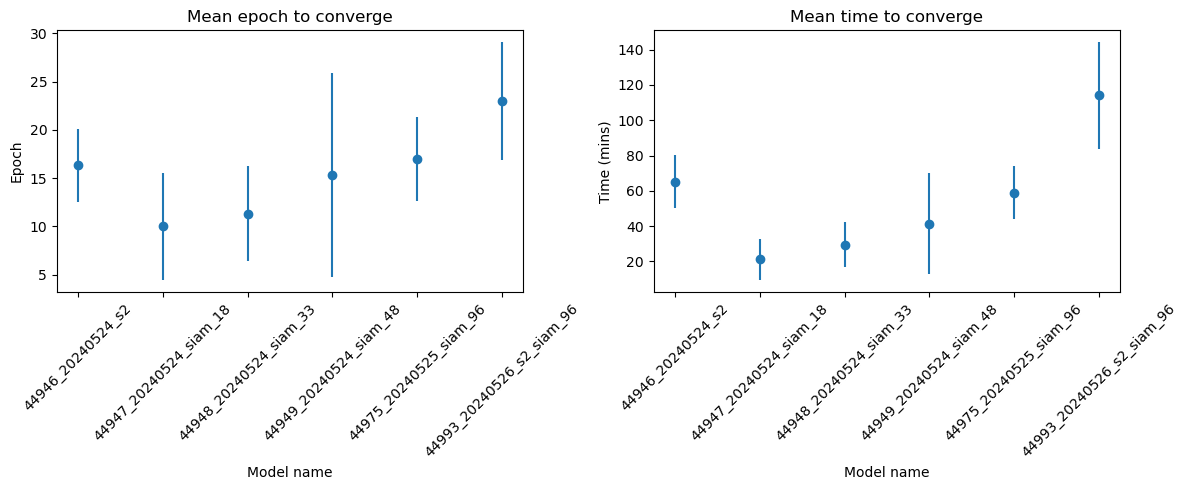

In [69]:
# plot avg time to converge with std_dev error bars
# plot  mean epoch to converge with error bars and avg time to converge with std_dev error bars, - 2 subplots

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize =(12,5))
axs[0].errorbar(summary_df['model_base_name'], summary_df['mean_thresh_epoch'], yerr=summary_df['std_dev_thresh_epoch'], fmt='o')
axs[0].set_title('Mean epoch to converge')
axs[0].set_xlabel('Model name')
axs[0].set_ylabel('Epoch')
axs[0].set_xticklabels(summary_df['model_base_name'], rotation=45)

axs[1].errorbar(summary_df['model_base_name'], summary_df['mean_time_to_converge'], yerr=summary_df['std_dev_time_to_converge'], fmt='o')
axs[1].set_title('Mean time to converge')
axs[1].set_xlabel('Model name')
axs[1].set_ylabel('Time (mins)')
axs[1].set_xticklabels(summary_df['model_base_name'], rotation=45)


plt.tight_layout()
plt.show()

